In [1]:
import sys
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import (
    RobustScaler,
    QuantileTransformer,
)
import optuna
from reservoirpy.observables import rmse

from model_configurations import get_ESN, ProcessedData

/home/francois/miniforge-pypy3/envs/reservoirs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 300
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize": (15, 10)})

In [3]:
CSV_FILE = "../../data/synthetic_bph_1/Simulations/01_test.csv"
N_CPU = 4
N_SEEDS = 5
FEATURE_THRESHOLD_FACTOR = 1e-2

In [4]:
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
data = data.sort_values(by=["individus", "temps"])
data

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,x2_x5,x4_x7,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,8.729390,8.605198,-6.255856,-6.144225,-2.996805,-2.991126,2.307527,2.279975,4.616573,4.615336,38.220878,38.163806,4.187466e+00,4.181621,0,-28.880618,9.662692e+00,-43.498706,-43.605232,-15.862629,-15.991621
1,1,1,9.075289,9.704948,-6.018428,-6.112985,-2.996020,-3.094470,2.252828,2.150593,2.317368,2.317199,39.248562,39.245740,3.712258e+00,3.709538,0,-13.946913,8.363078e+00,-20.211433,-20.401545,-7.797185,-7.829579
2,1,2,9.421187,9.596647,-5.879542,-5.801847,-2.993664,-2.938728,2.203334,2.420423,0.932058,0.930796,40.289880,40.332412,3.249134e+00,3.235153,0,-5.480074,7.158927e+00,-7.072602,-7.057319,-3.222236,-3.226070
3,1,3,9.767085,10.198744,-5.781001,-5.883516,-2.989738,-3.019894,2.158550,1.996865,0.334789,0.334388,41.344832,41.291154,2.808980e+00,2.806895,0,-1.935418,6.063324e+00,-1.653218,-1.594787,-1.304205,-1.367045
4,1,4,10.112983,9.873528,-5.704566,-5.616327,-2.984241,-2.908691,2.118027,1.878657,0.114954,0.113111,42.413417,42.368055,2.400529e+00,2.400502,0,-0.655763,5.084385e+00,0.223129,0.180240,-0.609093,-0.547249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,500,21,-2.462644,-2.583611,-1.008648,-1.005435,-3.012749,-3.218416,1.540358,1.520395,7.755539,7.756008,52.689242,52.714643,9.081671e-09,0.003654,1,-7.822612,1.398902e-08,1.100055,0.990910,-4.453522,-4.409573
12996,500,22,-2.972811,-3.602696,-0.961010,-0.870865,-3.008361,-3.028149,1.553460,1.607670,7.756674,7.756364,53.279452,53.282305,3.401095e-09,-0.003304,1,-7.454240,5.283465e-09,1.047838,1.071853,-4.254718,-4.326941
12997,500,23,-3.482978,-2.910034,-0.915399,-0.987839,-3.003769,-3.071758,1.565315,1.596924,7.757462,7.756919,53.872949,53.850949,1.273714e-09,-0.002870,1,-7.101176,1.993764e-09,0.997791,0.990856,-4.064175,-4.332440
12998,500,24,-3.993145,-3.816640,-0.871651,-0.968017,-2.998973,-2.887558,1.576042,1.661724,7.758010,7.759375,54.469734,54.366824,4.770072e-10,-0.007898,1,-6.762277,7.517835e-10,0.949751,0.920250,-3.881277,-3.802191


We'll use:
- features without noise
- target with noise and without random effects

In [5]:
SERIES_COLUMN_NAME = "individus"
TIMESTEPS_COLUMN_NAME = "temps"

group_labels = [SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME]

x_labels = [l for l in data.columns if l.startswith("x") and not l.endswith("obs")]
y_labels = [l for l in data.columns if l.startswith("y_fixed") and l.endswith("obs")]

data = data[group_labels + x_labels + y_labels]
data

,individus,temps,x1,x2,x3,x4,x5,x6,x7,x8,x2_x5,x4_x7,y_fixed_obs
0,1,0,8.729390,-6.255856,-2.996805,2.307527,4.616573,38.220878,4.187466e+00,0,-28.880618,9.662692e+00,-15.991621
1,1,1,9.075289,-6.018428,-2.996020,2.252828,2.317368,39.248562,3.712258e+00,0,-13.946913,8.363078e+00,-7.829579
2,1,2,9.421187,-5.879542,-2.993664,2.203334,0.932058,40.289880,3.249134e+00,0,-5.480074,7.158927e+00,-3.226070
3,1,3,9.767085,-5.781001,-2.989738,2.158550,0.334789,41.344832,2.808980e+00,0,-1.935418,6.063324e+00,-1.367045
4,1,4,10.112983,-5.704566,-2.984241,2.118027,0.114954,42.413417,2.400529e+00,0,-0.655763,5.084385e+00,-0.547249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,500,21,-2.462644,-1.008648,-3.012749,1.540358,7.755539,52.689242,9.081671e-09,1,-7.822612,1.398902e-08,-4.409573
12996,500,22,-2.972811,-0.961010,-3.008361,1.553460,7.756674,53.279452,3.401095e-09,1,-7.454240,5.283465e-09,-4.326941
12997,500,23,-3.482978,-0.915399,-3.003769,1.565315,7.757462,53.872949,1.273714e-09,1,-7.101176,1.993764e-09,-4.332440
12998,500,24,-3.993145,-0.871651,-2.998973,1.576042,7.758010,54.469734,4.770072e-10,1,-6.762277,7.517835e-10,-3.802191


# Helpers functions

$random seed \in [42, 52]$

In [6]:
get_ESN??

Signature: get_ESN(*, reservoir_kwargs: dict, ridge_kwargs: dict, esn_kwargs: dict) -> reservoirpy.nodes.esn.ESN
Docstring: <no docstring>
Source:   
def get_ESN(*, reservoir_kwargs: dict, ridge_kwargs: dict, esn_kwargs: dict) -> ESN:
    return ESN(
        reservoir=Reservoir(**reservoir_kwargs),
        readout=Ridge(**ridge_kwargs),
        **esn_kwargs,
    )
File:      ~/Documents/francois/SISTM/subSISTM/models/reservoirs-synthetic_bph/model_configurations.py
Type:      function

In [7]:
ProcessedData??

Init signature:
ProcessedData(
    data_train: pandas.core.frame.DataFrame,
    data_test: pandas.core.frame.DataFrame,
    series_column_name: str,
    timestep_column_name: str,
    x_labels: list[str],
    y_labels: list[str],
    x_scaler: sklearn.base.TransformerMixin,
    y_scaler: sklearn.base.TransformerMixin,
)
Docstring:      <no docstring>
Source:        
class ProcessedData:

    def __init__(
        self,
        data_train: DataFrame,
        data_test: DataFrame,
        series_column_name: str,
        timestep_column_name: str,
        x_labels: list[str],
        y_labels: list[str],
        x_scaler: TransformerMixin,
        y_scaler: TransformerMixin,
    ):
        P_x, P_y = len(x_labels), len(y_labels)

        N_train, T_train = _get_data_shape(
            data_train, series_column_name, timestep_column_name
        )
        N_test, T_test = _get_data_shape(
            data_test, series_column_name, timestep_column_name
        )

        x_train = data_tra

# Preparing the data

In [8]:
def get_processed_data_dict(
    data_train, data_test, series_column_name, TIMESTEPS_COLUMN_NAME, x_labels, y_labels
) -> dict[str, ProcessedData]:

    args = (
        data_train,
        data_test,
        series_column_name,
        TIMESTEPS_COLUMN_NAME,
        x_labels,
        y_labels,
    )

    return {
        "RobustScaler": ProcessedData(
            *args,
            RobustScaler(),
            RobustScaler(),
        ),
        "QuantileTransformer-uniform": ProcessedData(
            *args,
            QuantileTransformer(
                output_distribution="uniform", n_quantiles=len(data_train)
            ),
            QuantileTransformer(
                output_distribution="uniform", n_quantiles=len(data_train)
            ),
        ),
        "QuantileTransformer-normal": ProcessedData(
            *args,
            QuantileTransformer(
                output_distribution="normal", n_quantiles=len(data_train)
            ),
            QuantileTransformer(
                output_distribution="normal", n_quantiles=len(data_train)
            ),
        ),
    }

# Objective function for Optuna

We return 2 outputs:
- the RMSE
- the number of usefull features, defined by $scaling > k * max(abs(scaling))$

The idea is to see if Optuna can reduce the number of features, like in [Ferté2024] but using the scaling factors instead of a hard/boolean selection.

In [9]:
def optuna_objective(
    trial: optuna.Trial,
    processed_data_dict: dict[str, ProcessedData],
    feature_threshold_factor: float,
) -> float:

    processed_data = processed_data_dict[
        trial.suggest_categorical("scaler_name", list(processed_data_dict.keys()))
    ]

    reservoir_kwargs = {
        "units": trial.suggest_int("N", 50, 1000),
        "sr": trial.suggest_float("sr", 1e-2, 1e1, log=True),
        "lr": trial.suggest_float("lr", 1e-3, 1, log=True),
        "input_scaling": [
            trial.suggest_float(f"input_scaling_{i}", -10.0, 10.0, log=False)
            for i, _ in enumerate(x_labels)
        ],
    }

    ridge_kwargs = {
        "ridge": trial.suggest_float("ridge", 1e-8, 1e1, log=True),
    }

    esn_kwargs = {
        "workers": N_CPU,
        "feedback": trial.suggest_categorical("feedback", [True, False]),
    }

    list_rmse = []
    for reservoir_kwargs["seed"] in range(42, 42 + N_SEEDS):
        esn = get_ESN(
            reservoir_kwargs=reservoir_kwargs,
            ridge_kwargs=ridge_kwargs,
            esn_kwargs=esn_kwargs,
        )

        esn.fit(processed_data.x_train_3D, processed_data.y_train_3D)

        y_hat_run = esn.run(processed_data.x_test_3D)
        if isinstance(y_hat_run, np.ndarray):
            y_hat_run = [y_hat_run]
        y_hat_3D = np.array(y_hat_run)

        list_rmse.append(rmse(processed_data.y_test_3D, y_hat_3D))

    max_feature = max(abs(i) for i in reservoir_kwargs["input_scaling"])
    thresh = feature_threshold_factor * max_feature
    n_features = sum(i > thresh for i in reservoir_kwargs["input_scaling"])

    return (np.array(list_rmse).mean(), n_features)

In [10]:
def fix_axes(axs):
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])
    if isinstance(axs, np.ndarray):
        if len(axs.shape) != 2:
            axs = np.expand_dims(axs, axis=0)
    return axs


def plot_pred(data_pred_, ind_list=None):

    ind_uniq = data_pred_["individus"].unique()
    if ind_list is None:
        ind_list = ind_uniq
    else:
        assert all(i in ind_uniq for i in ind_list), f"{ind_list} / {ind_uniq}"
    fig, axs = plt.subplots(
        nrows=len(ind_list), ncols=2, figsize=(10 * 2, 5 * len(ind_list))
    )
    axs = fix_axes(axs)

    # y_values
    icol = 0
    for idx, ind in enumerate(ind_list):
        data_plot = data_pred_[data_pred_["individus"] == ind]
        data_plot = data_plot.melt(id_vars=["temps", "individus"])

        sns.lineplot(
            data_plot.sort_values(["variable"]),
            x="temps",
            y="value",
            hue="variable",
            style="variable",
            markers=True,
            ax=axs[idx, icol],
        )
        axs[idx, icol].set_title(f"Y value for individu #{ind}")

    # abs error
    icol = 1
    col_seed = [c for c in data_pred_.columns if "seed" in c]

    data_plot0 = data_pred_[["individus", "temps"] + col_seed]
    for col in col_seed:
        data_plot0.loc[:, col] = abs(data_pred_["y_fixed_obs"] - data_plot0[col])

    for idx, ind in enumerate(ind_list):
        data_plot = data_plot0[data_plot0["individus"] == ind]
        data_plot = data_plot.melt(id_vars=["temps", "individus"])

        sns.lineplot(
            data_plot.sort_values(["variable"]),
            x="temps",
            y="value",
            hue="variable",
            style="variable",
            markers=True,
            ax=axs[idx, icol],
        )
        axs[idx, icol].set_title(f"Absolute error for individu #{ind}")

# Test #1: one individual

We take the one with max y value.

In [36]:
STUDY_NAME = "test_01"
LOAD_IF_EXIST = True  # !!!!!!!!!!!

ind_max = data[data[y_labels[0]] == data[y_labels[0]].max()]["individus"]

ind_list = [ind_max.iloc[0]]

data_train = data[data["individus"].isin(ind_list)]
assert len(data_train) == len(ind_list) * 26  # remplacer par N_timesteps

data_test = data_train

processed_data_dict = get_processed_data_dict(
    data_train, data_test, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, x_labels, y_labels
)


# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
storage_name = f"sqlite:///{STUDY_NAME}.db"
study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize", "minimize"],
    load_if_exists=LOAD_IF_EXIST,  # !!!!!!!!!!!
)
study.set_metric_names(["RMSE", "nb. active features"])

if LOAD_IF_EXIST:
    print("study loaded!")
else:
    study.optimize(
        lambda x: optuna_objective(x, processed_data_dict, FEATURE_THRESHOLD_FACTOR),
        n_trials=200,
    )

[I 2024-10-17 16:15:41,293] Using an existing study with name 'test_01' instead of creating a new one.


study loaded!


/tmp/ipykernel_82159/1000629741.py:26: ExperimentalWarning:

set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.



/tmp/ipykernel_82159/2517046959.py:1: ExperimentalWarning:

plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.



<Axes: title={'center': 'Pareto-front Plot'}, xlabel='RMSE', ylabel='nb. active features'>

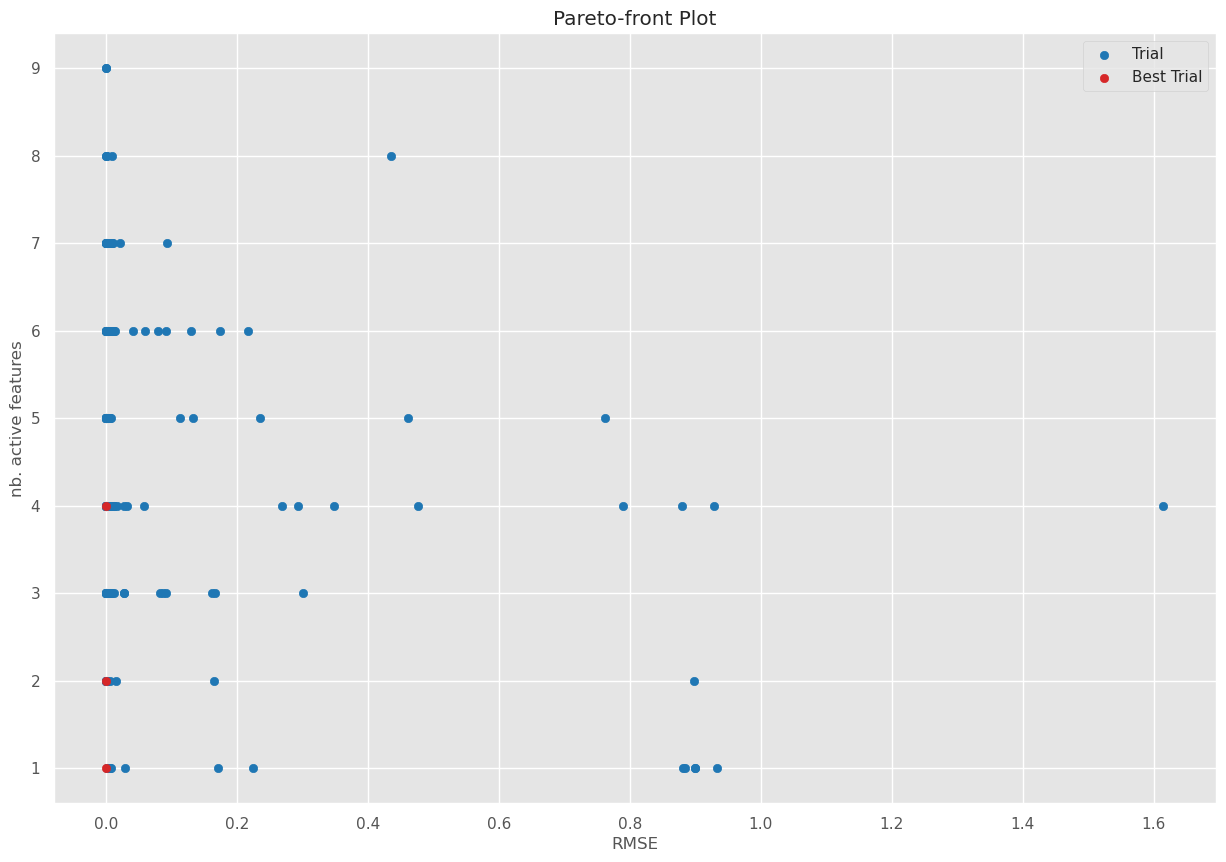

In [37]:
optuna.visualization.matplotlib.plot_pareto_front(
    study, target_names=["RMSE", "nb. active features"]
)

/tmp/ipykernel_82159/93722750.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

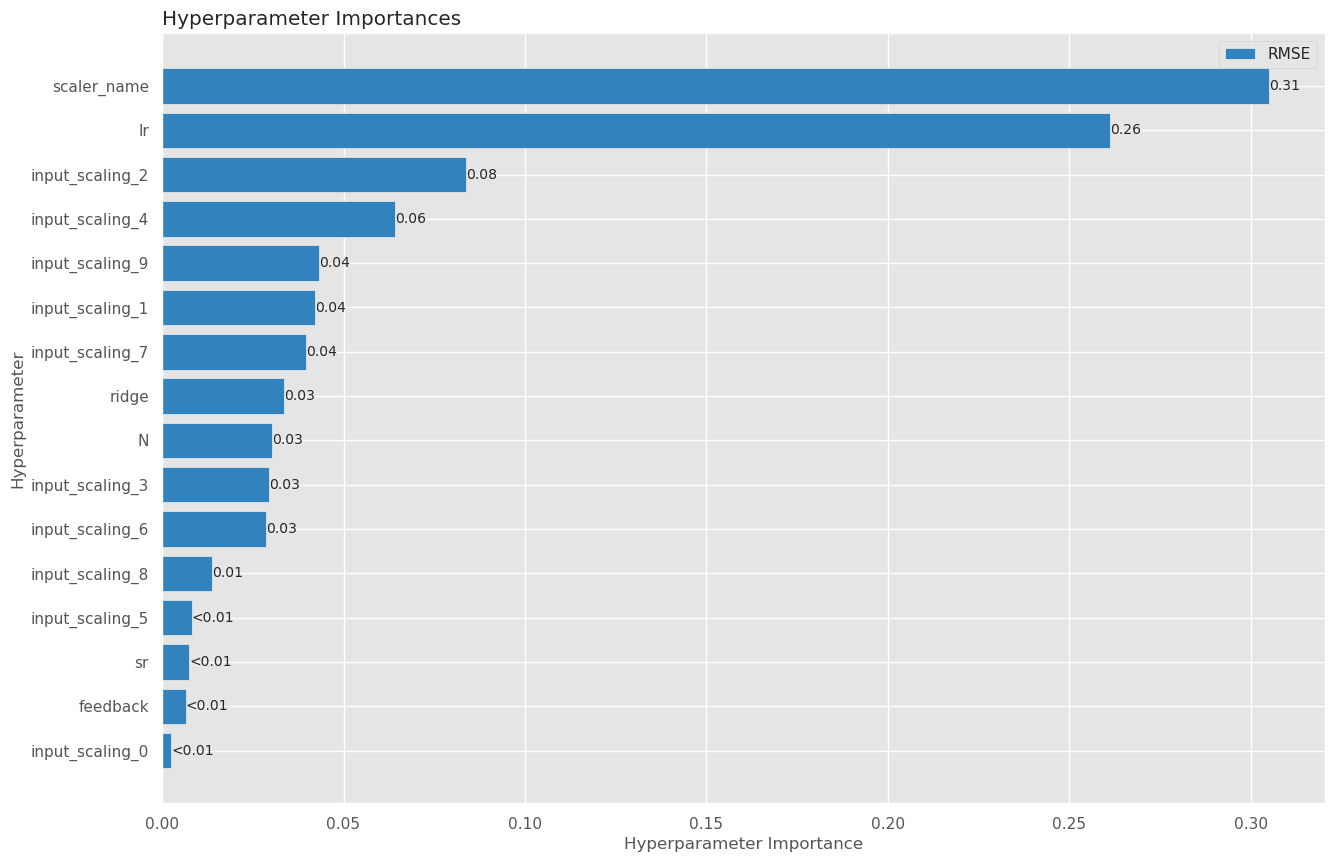

In [38]:
optuna.visualization.matplotlib.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="RMSE"
)

# Test #2 two individuals

We take the:
- one with max y value
- one with min y value

In [40]:
STUDY_NAME = "test_02"
LOAD_IF_EXISTS = True

ind_max = data[data[y_labels[0]] == data[y_labels[0]].max()]["individus"]
ind_min = data[data[y_labels[0]] == data[y_labels[0]].min()]["individus"]

ind_list = [ind_max.iloc[0], ind_min.iloc[0]]

data_train = data[data["individus"].isin(ind_list)]
assert len(data_train) == len(ind_list) * 26  # remplacer par N_timesteps

data_test = data_train

processed_data_dict = get_processed_data_dict(
    data_train, data_test, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, x_labels, y_labels
)


# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
storage_name = f"sqlite:///{STUDY_NAME}.db"
study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize", "minimize"],
    load_if_exists=LOAD_IF_EXISTS,  # !!!!!!!!!!!!
)
study.set_metric_names(["RMSE", "nb. active features"])

if LOAD_IF_EXISTS:
    print("Study loaded!")
else:
    study.optimize(
        lambda x: optuna_objective(x, processed_data_dict, FEATURE_THRESHOLD_FACTOR),
        n_trials=200,
    )

[I 2024-10-17 16:16:46,617] Using an existing study with name 'test_02' instead of creating a new one.


Study loaded!


/tmp/ipykernel_82159/881778756.py:27: ExperimentalWarning:

set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.



/tmp/ipykernel_82159/2517046959.py:1: ExperimentalWarning:

plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.



<Axes: title={'center': 'Pareto-front Plot'}, xlabel='RMSE', ylabel='nb. active features'>

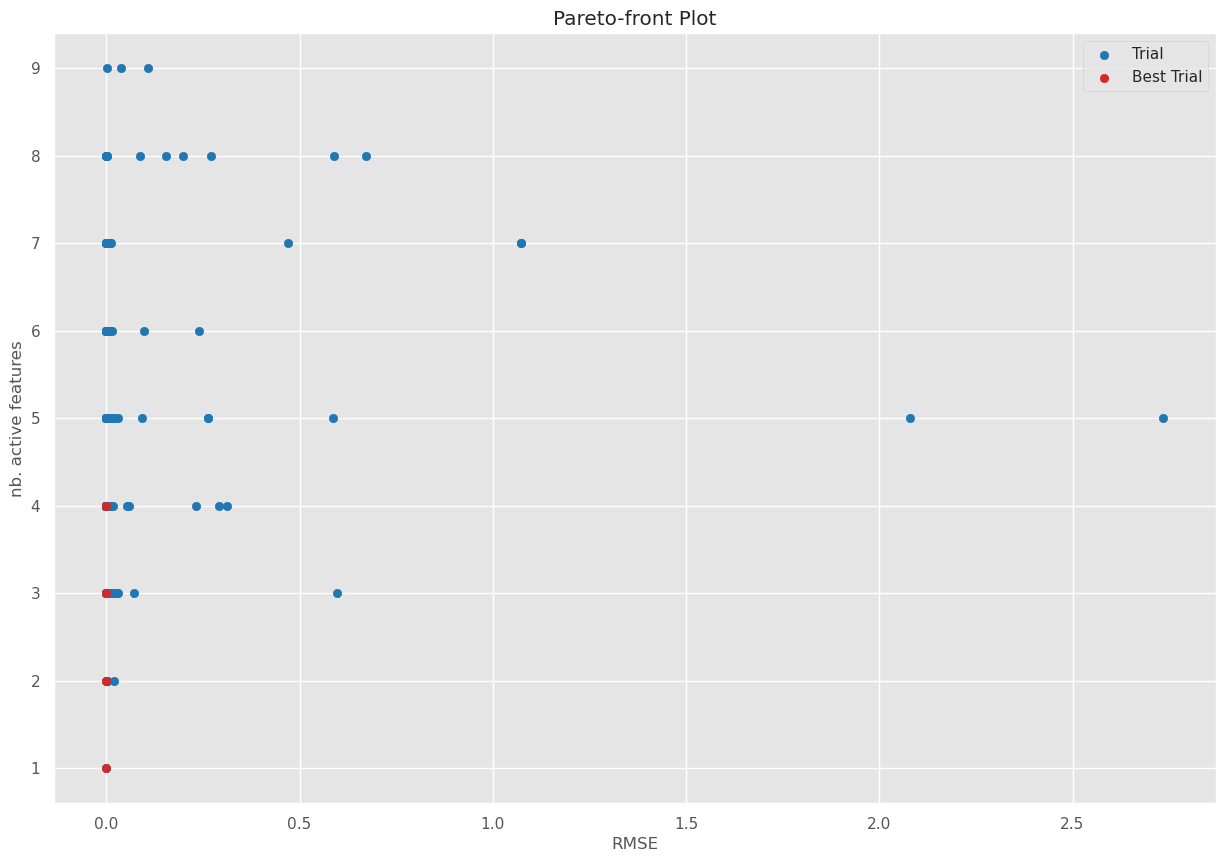

In [41]:
optuna.visualization.matplotlib.plot_pareto_front(
    study, target_names=["RMSE", "nb. active features"]
)

/tmp/ipykernel_82159/93722750.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

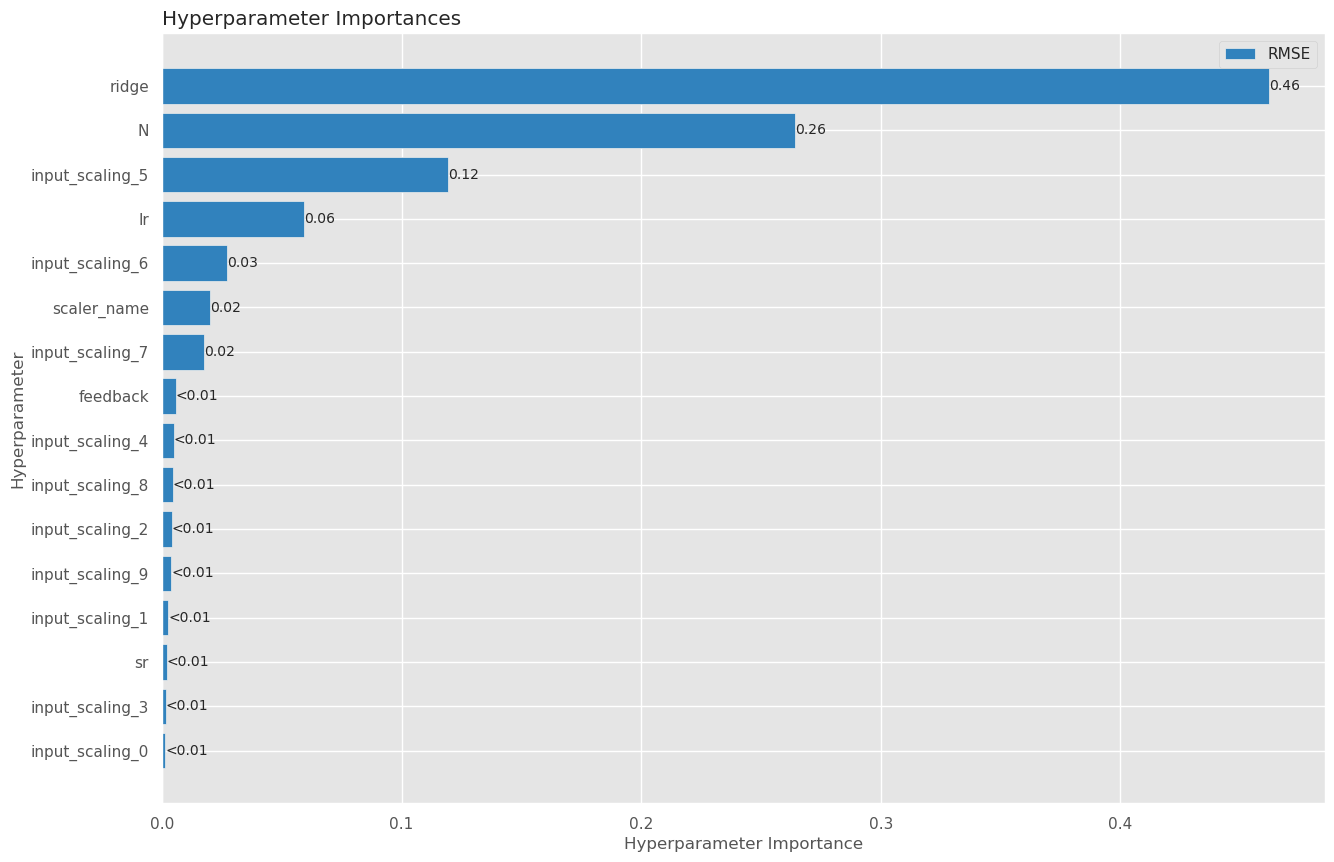

In [42]:
optuna.visualization.matplotlib.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="RMSE"
)

To be continued…

# Test on ten individuals

10 individuls sorted using their distribution mean value.


$N =100$  
$lr = 0.5$  
$sr = 0.9$  

In [87]:
data_pick_ind = (
    data[["individus"] + y_labels].groupby("individus").mean().sort_values(y_labels)
)
data_pick_ind

,y_fixed_obs
individus,
240,-337.674596
13,-329.136583
25,-276.026040
122,-216.331651
282,-196.672962
...,...
390,86.232958
269,88.869450
145,100.064637


In [88]:
ind_list = data_pick_ind.index[
    np.linspace(0, len(data_pick_ind) - 1, num=10).astype(int)
]
ind_list

Index([240, 321, 229, 219, 235, 445, 455, 164, 277, 103], dtype='int64', name='individus')

In [89]:
data_train = data[data["individus"].isin(ind_list)]
y_pred = train_and_pred(data_train, x_labels, y_labels, N=100, lr=0.5, sr=0.9)

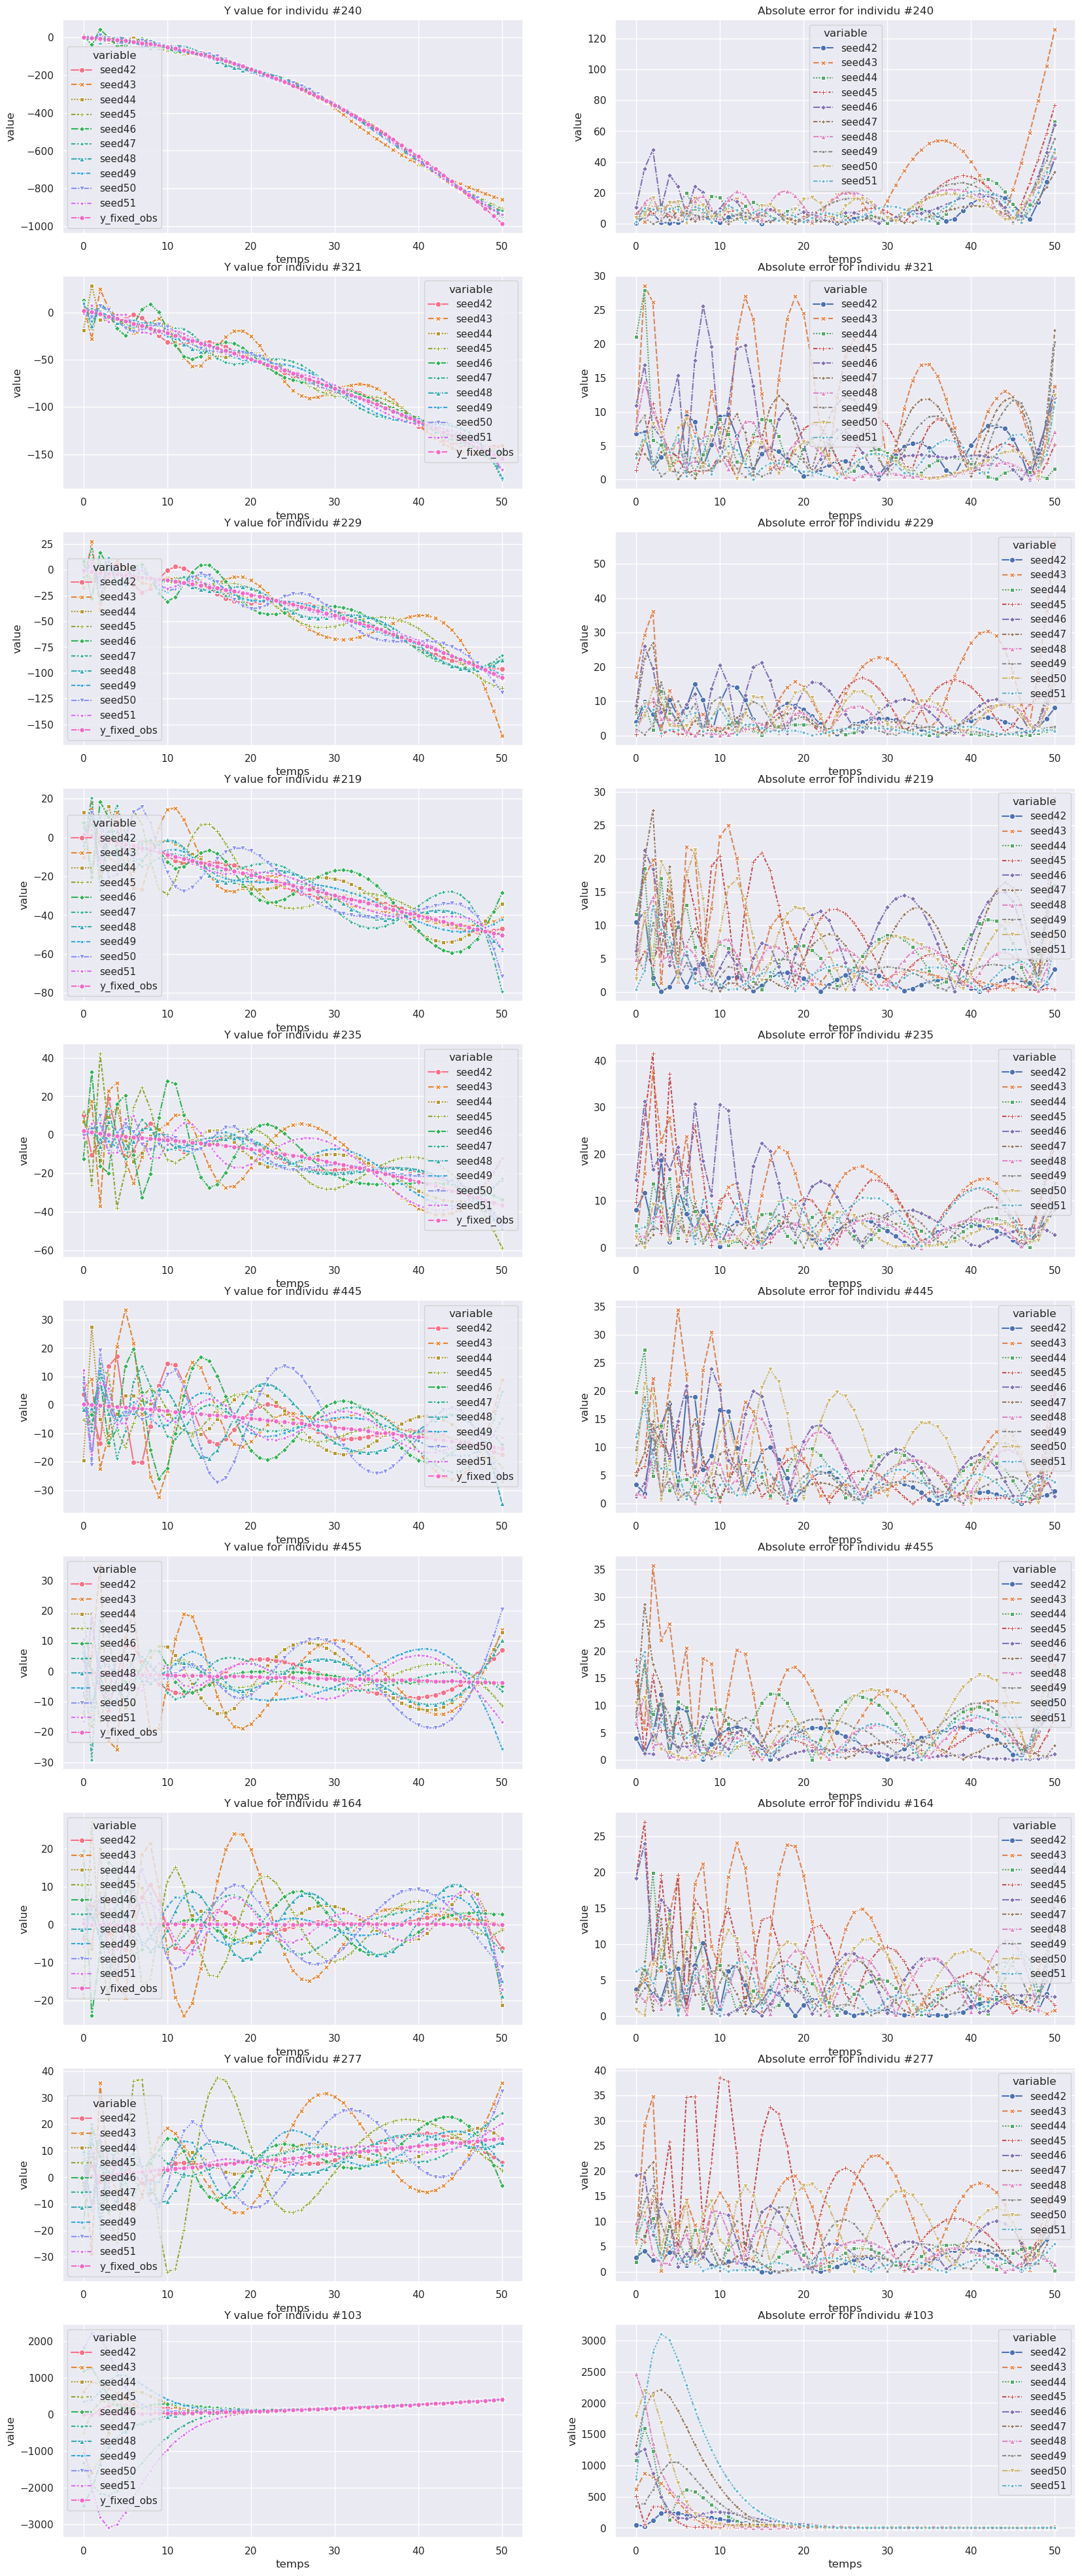

In [90]:
plot_pred(y_pred, ind_list)